# Method 7 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

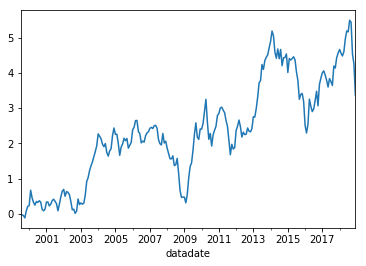

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.211859
2000-12-31   -0.068550
2001-12-31    0.453685
2002-12-31   -0.232055
2003-12-31    1.323538
2004-12-31    0.173407
2005-12-31   -0.118934
2006-12-31    0.099818
2007-12-31   -0.080800
2008-12-31   -0.518175
2009-12-31    1.311596
2010-12-31    0.111927
2011-12-31   -0.239525
2012-12-31    0.187043
2013-12-31    0.670876
2014-12-31   -0.030747
2015-12-31   -0.244493
2016-12-31    0.159627
2017-12-31    0.146237
2018-12-31   -0.214816
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     259.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.11e-84
Time:                        22:14:17   Log-Likelihood:                 440.50
No. Observations:                 234   AIC:                            -871.0
Df Residuals:                     229   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      2.100      0.037       0.000       0.010
mktrf          0.8920      0.069     12.846      0.000       0.755       1.029
me             0.9839      0.081     12.182      0.000       0.825       1.143
ia             0.5456      0.123      4.444      0.000       0.304       0.787
roe           -1.0632      0.105    -10.118      0.000      -1.270      -0.856
==============================================================================
Omnibus:                       27.472   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.088
Skew:                           0.747   Prob(JB):                     5.36e-09
Kurtosis:                       4.293   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     163.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.29e-66
Time:                        22:14:17   Log-Likelihood:                 440.50
No. Observations:                 234   AIC:                            -871.0
Df Residuals:                     229   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.698      0.089      -0.001       0.011
mktrf          0.8920      0.069     12.900      0.000       0.757       1.028
me             0.9839      0.102      9.628      0.000       0.784       1.184
ia             0.5456      0.164      3.319      0.001       0.223       0.868
roe           -1.0632      0.179     -5.953      0.000      -1.413      -0.713
==============================================================================
Omnibus:                       27.472   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.088
Skew:                           0.747   Prob(JB):                     5.36e-09
Kurtosis:                       4.293   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     170.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.03e-67
Time:                        22:14:17   Log-Likelihood:                 440.50
No. Observations:                 234   AIC:                            -871.0
Df Residuals:                     229   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.619      0.105      -0.001       0.012
mktrf          0.8920      0.065     13.657      0.000       0.764       1.020
me             0.9839      0.109      8.989      0.000       0.769       1.198
ia             0.5456      0.128      4.270      0.000       0.295       0.796
roe           -1.0632      0.192     -5.538      0.000      -1.439      -0.687
==============================================================================
Omnibus:                       27.472   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.088
Skew:                           0.747   Prob(JB):                     5.36e-09
Kurtosis:                       4.293   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     169.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-74
Time:                        22:14:17   Log-Likelihood:                 421.47
No. Observations:                 234   AIC:                            -830.9
Df Residuals:                     228   BIC:                            -810.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.168      0.244      -0.002       0.009
mktrf          1.0710      0.076     14.160      0.000       0.922       1.220
smb            1.0676      0.100     10.697      0.000       0.871       1.264
hml            0.2082      0.118      1.769      0.078      -0.024       0.440
rmw           -0.7315      0.133     -5.498      0.000      -0.994      -0.469
cma            0.4641      0.169      2.744      0.007       0.131       0.797
==============================================================================
Omnibus:                       46.040   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.325
Skew:                           1.042   Prob(JB):                     3.61e-18
Kurtosis:                       4.974   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     142.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.61e-68
Time:                        22:14:17   Log-Likelihood:                 421.47
No. Observations:                 234   AIC:                            -830.9
Df Residuals:                     228   BIC:                            -810.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      0.959      0.338      -0.003       0.010
mktrf          1.0710      0.063     17.083      0.000       0.948       1.194
smb            1.0676      0.125      8.574      0.000       0.824       1.312
hml            0.2082      0.208      1.001      0.317      -0.199       0.616
rmw           -0.7315      0.216     -3.393      0.001      -1.154      -0.309
cma            0.4641      0.238      1.949      0.051      -0.003       0.931
==============================================================================
Omnibus:                       46.040   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.325
Skew:                           1.042   Prob(JB):                     3.61e-18
Kurtosis:                       4.974   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     216.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.08e-84
Time:                        22:14:17   Log-Likelihood:                 421.47
No. Observations:                 234   AIC:                            -830.9
Df Residuals:                     228   BIC:                            -810.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      0.945      0.345      -0.004       0.010
mktrf          1.0710      0.063     17.080      0.000       0.948       1.194
smb            1.0676      0.123      8.656      0.000       0.826       1.309
hml            0.2082      0.198      1.051      0.293      -0.180       0.596
rmw           -0.7315      0.235     -3.110      0.002      -1.192      -0.270
cma            0.4641      0.213      2.183      0.029       0.048       0.881
==============================================================================
Omnibus:                       46.040   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.325
Skew:                           1.042   Prob(JB):                     3.61e-18
Kurtosis:                       4.974   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     208.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.20e-75
Time:                        22:14:17   Log-Likelihood:                 419.60
No. Observations:                 234   AIC:                            -829.2
Df Residuals:                     229   BIC:                            -811.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.971      0.333      -0.003       0.008
mktrf          1.0403      0.070     14.881      0.000       0.903       1.178
smb            1.4178      0.087     16.247      0.000       1.246       1.590
hml            0.3343      0.087      3.857      0.000       0.164       0.505
umd           -0.3373      0.057     -5.930      0.000      -0.449      -0.225
==============================================================================
Omnibus:                       42.018   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.242
Skew:                           0.860   Prob(JB):                     1.54e-20
Kurtosis:                       5.530   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     117.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.73e-54
Time:                        22:14:17   Log-Likelihood:                 419.60
No. Observations:                 234   AIC:                            -829.2
Df Residuals:                     229   BIC:                            -811.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.846      0.398      -0.003       0.009
mktrf          1.0403      0.069     15.185      0.000       0.906       1.175
smb            1.4178      0.115     12.311      0.000       1.192       1.643
hml            0.3343      0.191      1.748      0.081      -0.041       0.709
umd           -0.3373      0.106     -3.171      0.002      -0.546      -0.129
==============================================================================
Omnibus:                       42.018   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.242
Skew:                           0.860   Prob(JB):                     1.54e-20
Kurtosis:                       5.530   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     136.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-59
Time:                        22:14:17   Log-Likelihood:                 419.60
No. Observations:                 234   AIC:                            -829.2
Df Residuals:                     229   BIC:                            -811.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.844      0.399      -0.003       0.009
mktrf          1.0403      0.065     16.029      0.000       0.913       1.167
smb            1.4178      0.116     12.218      0.000       1.190       1.645
hml            0.3343      0.194      1.724      0.085      -0.046       0.714
umd           -0.3373      0.108     -3.134      0.002      -0.548      -0.126
==============================================================================
Omnibus:                       42.018   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.242
Skew:                           0.860   Prob(JB):                     1.54e-20
Kurtosis:                       5.530   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     130.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.32e-42
Time:                        22:14:17   Log-Likelihood:                 210.49
No. Observations:                 120   AIC:                            -411.0
Df Residuals:                     115   BIC:                            -397.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.004      2.664      0.009       0.003       0.019
mktrf          0.8485      0.110      7.696      0.000       0.630       1.067
me             0.9500      0.109      8.723      0.000       0.734       1.166
ia             0.4819      0.171      2.826      0.006       0.144       0.820
roe           -1.0518      0.151     -6.968      0.000      -1.351      -0.753
==============================================================================
Omnibus:                        8.789   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.873
Skew:                           0.543   Prob(JB):                       0.0118
Kurtosis:                       3.770   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     98.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.09e-36
Time:                        22:14:17   Log-Likelihood:                 210.49
No. Observations:                 120   AIC:                            -411.0
Df Residuals:                     115   BIC:                            -397.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.005      2.342      0.019       0.002       0.020
mktrf          0.8485      0.091      9.333      0.000       0.670       1.027
me             0.9500      0.145      6.535      0.000       0.665       1.235
ia             0.4819      0.227      2.124      0.034       0.037       0.927
roe           -1.0518      0.232     -4.529      0.000      -1.507      -0.597
==============================================================================
Omnibus:                        8.789   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.873
Skew:                           0.543   Prob(JB):                       0.0118
Kurtosis:                       3.770   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     102.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.55e-37
Time:                        22:14:17   Log-Likelihood:                 210.49
No. Observations:                 120   AIC:                            -411.0
Df Residuals:                     115   BIC:                            -397.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.005      2.155      0.031       0.001       0.021
mktrf          0.8485      0.084     10.057      0.000       0.683       1.014
me             0.9500      0.161      5.907      0.000       0.635       1.265
ia             0.4819      0.177      2.729      0.006       0.136       0.828
roe           -1.0518      0.254     -4.138      0.000      -1.550      -0.554
==============================================================================
Omnibus:                        8.789   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.873
Skew:                           0.543   Prob(JB):                       0.0118
Kurtosis:                       3.770   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     85.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.99e-37
Time:                        22:14:17   Log-Likelihood:                 201.16
No. Observations:                 120   AIC:                            -390.3
Df Residuals:                     114   BIC:                            -373.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.005      2.003      0.048    9.87e-05       0.018
mktrf          1.1799      0.126      9.348      0.000       0.930       1.430
smb            1.0979      0.143      7.680      0.000       0.815       1.381
hml            0.0064      0.175      0.036      0.971      -0.341       0.353
rmw           -0.5385      0.207     -2.607      0.010      -0.948      -0.129
cma            0.6081      0.226      2.687      0.008       0.160       1.056
==============================================================================
Omnibus:                       11.311   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.793
Skew:                           0.666   Prob(JB):                      0.00275
Kurtosis:                       3.766   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     73.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.99e-34
Time:                        22:14:17   Log-Likelihood:                 201.16
No. Observations:                 120   AIC:                            -390.3
Df Residuals:                     114   BIC:                            -373.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.005      1.674      0.094      -0.002       0.020
mktrf          1.1799      0.108     10.923      0.000       0.968       1.392
smb            1.0979      0.182      6.035      0.000       0.741       1.454
hml            0.0064      0.264      0.024      0.981      -0.511       0.523
rmw           -0.5385      0.284     -1.899      0.058      -1.094       0.017
cma            0.6081      0.290      2.098      0.036       0.040       1.176
==============================================================================
Omnibus:                       11.311   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.793
Skew:                           0.666   Prob(JB):                      0.00275
Kurtosis:                       3.766   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     139.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.99e-47
Time:                        22:14:17   Log-Likelihood:                 201.16
No. Observations:                 120   AIC:                            -390.3
Df Residuals:                     114   BIC:                            -373.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.006      1.532      0.125      -0.003       0.021
mktrf          1.1799      0.109     10.825      0.000       0.966       1.393
smb            1.0979      0.181      6.073      0.000       0.744       1.452
hml            0.0064      0.269      0.024      0.981      -0.521       0.534
rmw           -0.5385      0.316     -1.706      0.088      -1.157       0.080
cma            0.6081      0.256      2.379      0.017       0.107       1.109
==============================================================================
Omnibus:                       11.311   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.793
Skew:                           0.666   Prob(JB):                      0.00275
Kurtosis:                       3.766   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     110.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-38
Time:                        22:14:17   Log-Likelihood:                 202.21
No. Observations:                 120   AIC:                            -394.4
Df Residuals:                     115   BIC:                            -380.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.004      1.985      0.050    1.82e-05       0.017
mktrf          1.0332      0.104      9.927      0.000       0.827       1.239
smb            1.4370      0.118     12.126      0.000       1.202       1.672
hml            0.2540      0.119      2.140      0.034       0.019       0.489
umd           -0.3428      0.073     -4.685      0.000      -0.488      -0.198
==============================================================================
Omnibus:                       14.656   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.403
Skew:                           0.634   Prob(JB):                     3.71e-05
Kurtosis:                       4.572   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     62.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.83e-28
Time:                        22:14:17   Log-Likelihood:                 202.21
No. Observations:                 120   AIC:                            -394.4
Df Residuals:                     115   BIC:                            -380.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.004      1.935      0.053      -0.000       0.017
mktrf          1.0332      0.092     11.222      0.000       0.853       1.214
smb            1.4370      0.143     10.023      0.000       1.156       1.718
hml            0.2540      0.258      0.986      0.324      -0.251       0.759
umd           -0.3428      0.116     -2.946      0.003      -0.571      -0.115
==============================================================================
Omnibus:                       14.656   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.403
Skew:                           0.634   Prob(JB):                     3.71e-05
Kurtosis:                       4.572   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     74.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.26e-31
Time:                        22:14:17   Log-Likelihood:                 202.21
No. Observations:                 120   AIC:                            -394.4
Df Residuals:                     115   BIC:                            -380.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.004      1.927      0.054      -0.000       0.017
mktrf          1.0332      0.090     11.511      0.000       0.857       1.209
smb            1.4370      0.153      9.390      0.000       1.137       1.737
hml            0.2540      0.275      0.924      0.356      -0.285       0.793
umd           -0.3428      0.115     -2.982      0.003      -0.568      -0.117
==============================================================================
Omnibus:                       14.656   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.403
Skew:                           0.634   Prob(JB):                     3.71e-05
Kurtosis:                       4.572   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     141.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.82e-42
Time:                        22:14:17   Log-Likelihood:                 242.21
No. Observations:                 114   AIC:                            -474.4
Df Residuals:                     109   BIC:                            -460.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.298      0.766      -0.007       0.005
mktrf          1.0044      0.087     11.555      0.000       0.832       1.177
me             0.9127      0.134      6.801      0.000       0.647       1.179
ia             0.5164      0.186      2.774      0.007       0.147       0.885
roe           -1.2628      0.164     -7.721      0.000      -1.587      -0.939
==============================================================================
Omnibus:                       11.118   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.697
Skew:                           0.658   Prob(JB):                      0.00288
Kurtosis:                       3.854   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     279.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.51e-56
Time:                        22:14:17   Log-Likelihood:                 242.21
No. Observations:                 114   AIC:                            -474.4
Df Residuals:                     109   BIC:                            -460.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.289      0.773      -0.007       0.005
mktrf          1.0044      0.080     12.583      0.000       0.848       1.161
me             0.9127      0.088     10.330      0.000       0.740       1.086
ia             0.5164      0.131      3.928      0.000       0.259       0.774
roe           -1.2628      0.255     -4.945      0.000      -1.763      -0.762
==============================================================================
Omnibus:                       11.118   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.697
Skew:                           0.658   Prob(JB):                      0.00288
Kurtosis:                       3.854   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     434.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.42e-66
Time:                        22:14:17   Log-Likelihood:                 242.21
No. Observations:                 114   AIC:                            -474.4
Df Residuals:                     109   BIC:                            -460.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.313      0.755      -0.006       0.005
mktrf          1.0044      0.064     15.789      0.000       0.880       1.129
me             0.9127      0.079     11.541      0.000       0.758       1.068
ia             0.5164      0.111      4.641      0.000       0.298       0.735
roe           -1.2628      0.225     -5.619      0.000      -1.703      -0.822
==============================================================================
Omnibus:                       11.118   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.697
Skew:                           0.658   Prob(JB):                      0.00288
Kurtosis:                       3.854   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     96.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.14e-38
Time:                        22:14:17   Log-Likelihood:                 235.34
No. Observations:                 114   AIC:                            -458.7
Df Residuals:                     108   BIC:                            -442.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.004      0.318      -0.009       0.003
mktrf          1.0824      0.088     12.236      0.000       0.907       1.258
smb            0.9125      0.144      6.355      0.000       0.628       1.197
hml            0.4660      0.183      2.544      0.012       0.103       0.829
rmw           -1.0278      0.224     -4.583      0.000      -1.472      -0.583
cma            0.0822      0.285      0.289      0.773      -0.482       0.647
==============================================================================
Omnibus:                       28.665   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.854
Skew:                           0.989   Prob(JB):                     3.70e-14
Kurtosis:                       6.018   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     110.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.50e-41
Time:                        22:14:17   Log-Likelihood:                 235.34
No. Observations:                 114   AIC:                            -458.7
Df Residuals:                     108   BIC:                            -442.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.062      0.288      -0.009       0.003
mktrf          1.0824      0.079     13.623      0.000       0.927       1.238
smb            0.9125      0.103      8.859      0.000       0.711       1.114
hml            0.4660      0.161      2.888      0.004       0.150       0.782
rmw           -1.0278      0.339     -3.035      0.002      -1.692      -0.364
cma            0.0822      0.209      0.393      0.694      -0.328       0.493
==============================================================================
Omnibus:                       28.665   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.854
Skew:                           0.989   Prob(JB):                     3.70e-14
Kurtosis:                       6.018   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     122.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.55e-43
Time:                        22:14:17   Log-Likelihood:                 235.34
No. Observations:                 114   AIC:                            -458.7
Df Residuals:                     108   BIC:                            -442.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.379      0.168      -0.008       0.001
mktrf          1.0824      0.071     15.282      0.000       0.944       1.221
smb            0.9125      0.115      7.944      0.000       0.687       1.138
hml            0.4660      0.170      2.742      0.006       0.133       0.799
rmw           -1.0278      0.358     -2.869      0.004      -1.730      -0.326
cma            0.0822      0.229      0.360      0.719      -0.366       0.530
==============================================================================
Omnibus:                       28.665   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.854
Skew:                           0.989   Prob(JB):                     3.70e-14
Kurtosis:                       6.018   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.07e-36
Time:                        22:14:17   Log-Likelihood:                 227.93
No. Observations:                 114   AIC:                            -445.9
Df Residuals:                     109   BIC:                            -432.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.217      0.226      -0.011       0.003
mktrf          1.1212      0.093     12.009      0.000       0.936       1.306
smb            1.1472      0.146      7.881      0.000       0.859       1.436
hml            0.5654      0.150      3.771      0.000       0.268       0.863
umd           -0.2971      0.113     -2.627      0.010      -0.521      -0.073
==============================================================================
Omnibus:                       31.269   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.883
Skew:                           0.979   Prob(JB):                     3.70e-19
Kurtosis:                       6.746   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     232.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-52
Time:                        22:14:17   Log-Likelihood:                 227.93
No. Observations:                 114   AIC:                            -445.9
Df Residuals:                     109   BIC:                            -432.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.360      0.174      -0.010       0.002
mktrf          1.1212      0.077     14.542      0.000       0.970       1.272
smb            1.1472      0.110     10.424      0.000       0.932       1.363
hml            0.5654      0.159      3.556      0.000       0.254       0.877
umd           -0.2971      0.093     -3.209      0.001      -0.479      -0.116
==============================================================================
Omnibus:                       31.269   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.883
Skew:                           0.979   Prob(JB):                     3.70e-19
Kurtosis:                       6.746   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     289.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.33e-57
Time:                        22:14:17   Log-Likelihood:                 227.93
No. Observations:                 114   AIC:                            -445.9
Df Residuals:                     109   BIC:                            -432.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.469      0.142      -0.009       0.001
mktrf          1.1212      0.062     17.977      0.000       0.999       1.243
smb            1.1472      0.080     14.370      0.000       0.991       1.304
hml            0.5654      0.158      3.588      0.000       0.257       0.874
umd           -0.2971      0.074     -4.015      0.000      -0.442      -0.152
==============================================================================
Omnibus:                       31.269   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.883
Skew:                           0.979   Prob(JB):                     3.70e-19
Kurtosis:                       6.746   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""